In [26]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv

load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-finetuned-relations", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-finetuned-relations")

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

from lib.bert import get_cls_embedding
from lib.examples import examples_df

embeddings = []
labels = []

model.bert.eval()
for _, row in tqdm(examples_df.iterrows(), total=len(examples_df), desc="Encoding examples"):
    emb = get_cls_embedding(row["concept1"], row["concept2"], model.bert, tokenizer)
    embeddings.append(emb)
    labels.append(row["relation"])


similarity_matrix = cosine_similarity(embeddings)

N = len(labels)
gt_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if labels[i] == labels[j]:
            gt_matrix[i, j] = 1

def flatten_upper_tri(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

rsa_score, pvalue = spearmanr(flatten_upper_tri(similarity_matrix), flatten_upper_tri(gt_matrix))
print("RSA score (Spearman correlation):", rsa_score)
print("P-value:", pvalue)

Encoding examples:   0%|          | 0/3600 [00:00<?, ?it/s]

Encoding examples: 100%|██████████| 3600/3600 [02:35<00:00, 23.08it/s]


RSA score (Spearman correlation): 0.7705695916570381
P-value: 0.0


/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/colegawin/Documents/ling 486 final project/.venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


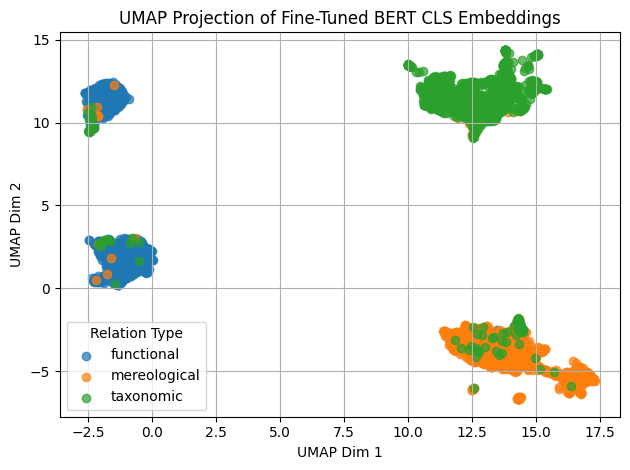

In [29]:
import umap
import matplotlib.pyplot as plt

# Create a UMAP object
X = np.array(embeddings)
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Use the same label encoder from before
relation_names = sorted(set(labels))
colors = ["blue", "orange", "green"]  # Adjust if you have more classes

for i, rel in enumerate(relation_names):
    idx = [j for j, label in enumerate(labels) if label == rel]
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=rel, alpha=0.7)

plt.title("UMAP Projection of Fine-Tuned BERT CLS Embeddings")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Relation Type")
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
score = silhouette_score(X, label_encoder.fit_transform(labels), metric='cosine')

print("Silhouette score:", score)

Silhouette score: 0.8530866


# Layer-wise RSA

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
import numpy as np

from lib.bert import get_layerwise_embeddings

# Store embeddings per layer: list of length 13 (layers 0–12), each with N x 768 matrix
num_layers = 13  # includes embedding layer (0) + 12 transformer layers
layer_embeddings = [[] for _ in range(num_layers)]
labels = []

# Collect embeddings for all concept pairs
for _, row in tqdm(examples_df.iterrows(), total=len(examples_df), desc="Encoding examples"):
    layerwise = get_layerwise_embeddings(row["concept1"], row["concept2"], model.bert, tokenizer)
    for l in range(num_layers):
        layer_embeddings[l].append(layerwise[l])
    labels.append(row["relation"])

# Convert to arrays per layer
layer_embeddings = [np.array(e) for e in layer_embeddings]


Encoding examples:   0%|          | 0/3600 [00:00<?, ?it/s]

Encoding examples: 100%|██████████| 3600/3600 [02:31<00:00, 23.77it/s]


In [6]:
def compute_rsa_score(embeddings, labels):
    # Cosine similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    
    # Ground truth: 1 if same label, else 0
    N = len(labels)
    label_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if labels[i] == labels[j]:
                label_matrix[i, j] = 1
    
    # Spearman correlation between upper triangles
    def flatten_upper_tri(m): return m[np.triu_indices_from(m, k=1)]
    sim_flat = flatten_upper_tri(sim_matrix)
    label_flat = flatten_upper_tri(label_matrix)

    rsa_score, _ = spearmanr(sim_flat, label_flat)
    return rsa_score

# Compute RSA per layer
rsa_per_layer = [compute_rsa_score(layer_embeddings[l], labels) for l in range(num_layers)]

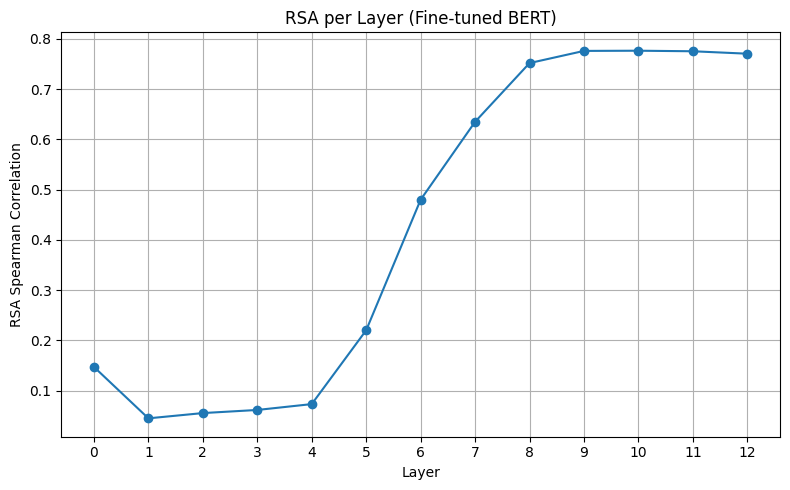

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(num_layers), rsa_per_layer, marker='o')
plt.xticks(range(num_layers))
plt.xlabel("Layer")
plt.ylabel("RSA Spearman Correlation")
plt.title("RSA per Layer (Fine-tuned BERT)")
plt.grid(True)
plt.tight_layout()
plt.show()
